# Verifiaction of acoustic modeling with the MMS method

We verify the accuracy and convergence of our finite-difference acoustic modeling kernel in an heterogeneous belocity model with the MMS method

# Seismic modelling with devito

We describe here a step by step setup of seismic modelling with Devito in a simple 2D case. We will create a physical model of our domain and define a single source and an according set of receivers to model for the forward model. But first, we initialize some basic utilities.

In [1]:
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver
from devito import clear_cache, set_log_level
from devito import *
#from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from examples.seismic import Model
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1*self.spacing[0]

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and grid spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .07

In [4]:
# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(.5, .5), shape=(801, 801), nbpml=40, space_order=0, dtype=np.float64)

# Make a three layers velocity model

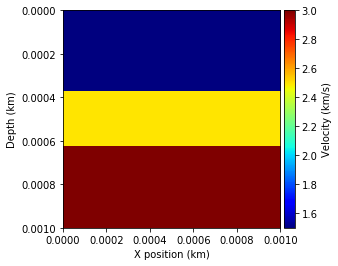

In [23]:
from examples.seismic import Model, plot_velocity
v = 1.5 * np.ones((201, 201))
v[:, 75:] = 2.5
v[:, 125:] = 3.0
model = ModelBench(vp=v, origin=(0., 0.), spacing=(.005, .005), shape=(201, 201), nbpml=0, space_order=0, dtype=np.float64)
plot_velocity(model)

# Analytical solution definition

In [6]:
x, z = model.grid.dimensions
t = model.grid.time_dim

In [7]:
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

In [8]:
# sol = sin(2*np.pi*t.spacing*t/10)* exp(-(x.spacing*x - 100)**2/200 - (z.spacing*z - 100)**2/200)
import sympy
u, v, w, c = sympy.symbols('u v w c')
sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)

# Corresponding source

In [9]:
source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)

In [10]:
sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})

# Wave equation

In [11]:
u = TimeFunction(name="u", grid=model.grid, space_order=16, time_order=2)
u_true = TimeFunction(name="utrue", grid=model.grid, space_order=0, time_order=2)
src = TimeFunction(name="src", grid=model.grid, space_order=0, time_order=2)

In [12]:
wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))

In [13]:
true_eqq = Eq(u_true, sol)

In [14]:
src_eq = Eq(src, source)

In [15]:
# inital conditions, t=1
u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))

In [16]:
## from devito import configuration
configuration["log-level"] = "ERROR"
h = .00125
op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: .1*h, x.spacing:h, z.spacing:h}))
op.apply(t_m=1, t_M=100)

PerformanceSummary([('section0',
                     PerfEntry(time=0.07780200000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [17]:
def mms_sol(model):
    u, v, w, c = sympy.symbols('u v w c')
#     sol = 1e2*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)
    sol = (1e4*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
           1e3*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
           5000*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
           1e4*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
           5*1e3*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
    source =  model.m*sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    x, z = model.grid.dimensions
    t = model.grid.time_dim
    
    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    source = source.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    
    return sol, source

In [18]:
def get_solution(size, space_order):
    clear_cache()
    # Model
    v = 1.5 * np.ones((size, size))
    v[:, 75:] = 2.5
    v[:, 125:] = 3.0
    model = ModelBench(vp=v, origin=(0., 0.), spacing=(1., 1.), shape=(size, size),
                       nbpml=0, space_order=0, dtype=np.float64)
    x, z = model.grid.dimensions
    t = model.grid.time_dim
    # Grid
    h = 1./(size - 1)
    dt = 1e-7
    nt = 350
    # Wave equation
    u = TimeFunction(name="u", grid=model.grid, space_order=space_order, time_order=2, save=nt)
    u_true = TimeFunction(name="utrue", grid=model.grid, space_order=space_order, time_order=0, save=nt)
    src = TimeFunction(name="src", grid=model.grid, space_order=space_order, time_order=0, save=nt)

    sol, source = mms_sol(model)
    
    wave_eq = Eq(u.forward, 2 * u - u.backward + t.spacing**2/model.m * (u.laplace + src))
    true_eqq = Eq(u_true, sol)

    src_eq = Eq(src, source)
    
    u_1 = Eq(u.subs(t, 1), sol.subs(t, 1))
    configuration["log-level"] = "ERROR"
    op = Operator([u_1, true_eqq, src_eq, wave_eq], subs=({t.spacing: dt, x.spacing:h, z.spacing:h}))
    op.apply()

    error = np.linalg.norm(u.data[(nt-3), :, :].reshape(-1) -
                           u_true.data[(nt-3), :, :].reshape(-1), 2)*h
#     import matplotlib.pyplot as plt
#     plt.figure()
#     plt.subplot(131)
#     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(132)
#     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(133)
#     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.show()
    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))
    return error

# MMS

In [19]:
size = [26, 51, 101, 201]
t = 2
so = [2, 4, 6, 8, 10]
error = np.zeros((4, 5))
hh = [0.04, 0.02, 0.01, 0.005]
# hh = [1, .5, .25, .125]
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution(s, sso)

for h = 0.040000 and dt= 1.00e-07 ms error is 1.0279e-07
for h = 0.040000 and dt= 1.00e-07 ms error is 6.6287e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 5.3194e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 4.6730e-08
for h = 0.040000 and dt= 1.00e-07 ms error is 4.2943e-08
for h = 0.020000 and dt= 1.00e-07 ms error is 3.1249e-08
for h = 0.020000 and dt= 1.00e-07 ms error is 8.2700e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 3.3798e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 1.7486e-09
for h = 0.020000 and dt= 1.00e-07 ms error is 1.0477e-09
for h = 0.010000 and dt= 1.00e-07 ms error is 8.2428e-09
for h = 0.010000 and dt= 1.00e-07 ms error is 6.3765e-10
for h = 0.010000 and dt= 1.00e-07 ms error is 8.4397e-11
for h = 0.010000 and dt= 1.00e-07 ms error is 1.5512e-11
for h = 0.010000 and dt= 1.00e-07 ms error is 3.6080e-12
for h = 0.005000 and dt= 1.00e-07 ms error is 5.9643e-09
for h = 0.005000 and dt= 1.00e-07 ms error is 1.1850e-10
for h = 0.005000 and dt= 1.00e-

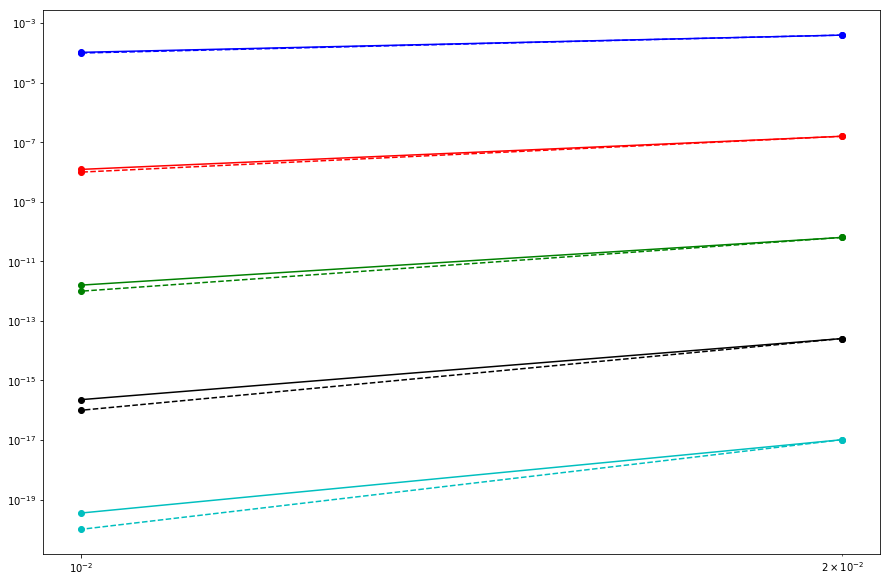

In [20]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
hh = [0.04, 0.02, 0.01, 0.005]
plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:3], hh[1]**so[j]*error[1:3, j]/error[1, j], col[j])
    plt.loglog(hh[1:3], [h**so[j] for h in hh][1:3], col_2[j])

# plt.loglog(hh, error[:, 3])
# plt.loglog(hh, [h**so[3] for h in hh])

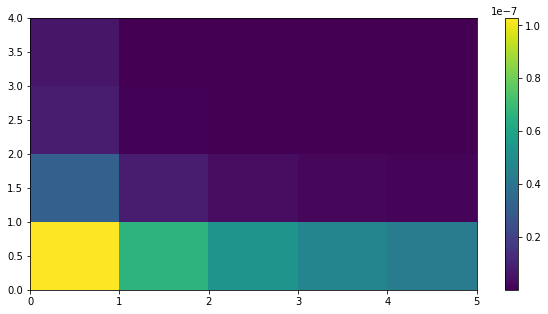

In [21]:
fig = plt.figure(figsize=(10, 5))
im = plt.pcolormesh(error)
fig.colorbar(im)